<h1 style=\"text-align: center; font-size: 50px;\">🖼️ Image Super Resolution with FSRCNN Model </h1>

In this template, our objective is to increase the resolution of images (i.e., increase the number of pixels) using the FSRCNN model. This convolutional neural network model offers greater run-time speed, taking a low-resolution image as input and returning a higher-resolution image that is x times larger.

# Notebook Overview
- Start Execution
- Install and Import Libraries
- Configure Settings
- Model architecture and implementation
- Dataloader / preprocessing
- Training and Validation
- Inference
- HR and LR image comparasion

## Start Execution

In [1]:
import logging
import time

# Configure logger
logger: logging.Logger = logging.getLogger("run_workflow_logger")
logger.setLevel(logging.INFO)
logger.propagate = False  # Prevent duplicate logs from parent loggers

# Set formatter
formatter: logging.Formatter = logging.Formatter(
    fmt="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

# Configure and attach stream handler
stream_handler: logging.StreamHandler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

In [2]:
start_time = time.time()  

logger.info("Notebook execution started.")

2025-07-16 16:09:54 - INFO - Notebook execution started.


## Install and Import Libraries

In [3]:
# ------------------------ Standard Library Imports ------------------------
import logging
from datetime import datetime
from pathlib import Path
import argparse
import os
import copy
import time
import warnings
import pandas as pd

# ------------------------ Third-Party Libraries ------------------------
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import tensorflow as tf
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import base64
import io
from io import BytesIO



# ------------------------ MLflow for Experiment Tracking and Model Management ------------------------
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec, TensorSpec, ParamSchema, ParamSpec

2025-07-16 16:09:56.760664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 16:09:56.772158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752682196.785325    2013 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752682196.789453    2013 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-16 16:09:56.804903: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Configure Settings

In [4]:
warnings.filterwarnings("ignore")

In [5]:
# ------------------------ MLflow Integration AND MODEL NAME------------------------
PROJECT_NAME = "super_resolution"
RUN_NAME = "fsrcnn_metrics"
MODEL_NAME = "fsrcnn"
MLFLOW_EXPERIMENT = "Super Resolution 4x"
# ------------------------- Paths -------------------------
TENSORLOGS_PATH = "/phoenix/tensorboard/tensorlogs"
TRAIN_PATH = "/home/jovyan/datafabric/DIV2K/DIV2K_train_HR/"
VALIDATION_PATH = "/home/jovyan/datafabric/DIV2K/DIV2K_valid_HR/"
BEST_MODEL_PATH = "best_model.pth"
MODEL_PATH = "FSRCNN_300_epochs.pt"

os.environ["TENSORBOARD_LOGDIR"] = "/phoenix/tensorboard"

## Verify Assets

In [6]:
def log_asset_status(
    asset_path: str, asset_name: str, success_message: str, failure_message: str
) -> None:
    """
    Logs the status of a given asset based on its existence.

    Parameters:
        asset_path (str): File or directory path to check.
        asset_name (str): Name of the asset for logging context.
        success_message (str): Message to log if asset exists.
        failure_message (str): Message to log if asset does not exist.
    """
    if Path(asset_path).exists():
        logger.info(f"{asset_name} is properly configured. {success_message}")
    else:
        logger.info(f"{asset_name} is not properly configured. {failure_message}")


log_asset_status(
    asset_path=TRAIN_PATH,
    asset_name="Train data",
    success_message="",
    failure_message="Please create and download the required assets in your project on AI Studio.",
)
log_asset_status(
    asset_path=VALIDATION_PATH,
    asset_name="Validation data",
    success_message="",
    failure_message="Please create and download the required assets in your project on AI Studio.",
)

2025-07-16 16:09:58 - INFO - Train data is properly configured. 
2025-07-16 16:09:58 - INFO - Validation data is properly configured. 


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Model architecture and implementation
The FSRCNN model works as follows:
- Low Resolution (LR) image as input
- Feature extraction
- Shrinking
- Non-Linear mapping
- Expanding
- Decovolution
- Super resolution (SR) image as output

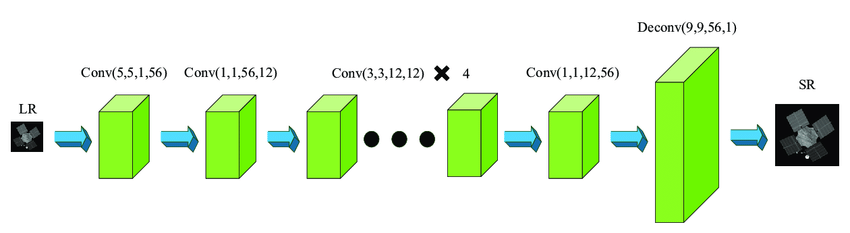


In [8]:
class FSRCNN(nn.Module):
    """
    A class for building the architecture of the FSRCNN model.
    """

    def __init__(self, scale_factor):
        """
        Initializes the FSRCNN.
        Args:
            scale_factor: The factor by which to upscale the image.
        """
        try:
            super(FSRCNN, self).__init__()
            self.scale_factor = scale_factor

            self.feature_extraction = nn.Sequential(
                nn.Conv2d(3, 56, kernel_size=5, padding=2), nn.PReLU()
            )
            self.shrinking = nn.Sequential(nn.Conv2d(56, 12, kernel_size=1), nn.PReLU())
            self.non_linear_mapping = nn.Sequential(
                nn.Conv2d(12, 12, kernel_size=3, padding=1),
                nn.PReLU(),
                nn.Conv2d(12, 12, kernel_size=3, padding=1),
                nn.PReLU(),
                nn.Conv2d(12, 12, kernel_size=3, padding=1),
                nn.PReLU(),
                nn.Conv2d(12, 12, kernel_size=3, padding=1),
                nn.PReLU(),
                nn.Conv2d(12, 12, kernel_size=3, padding=1),
                nn.PReLU(),
            )
            self.expanding = nn.Sequential(nn.Conv2d(12, 56, kernel_size=1), nn.PReLU())
            self.deconvolution = nn.ConvTranspose2d(
                56,
                3,
                kernel_size=9,
                stride=scale_factor,
                padding=4,
                output_padding=scale_factor - 1,
            )

            logger.info("FSRCNN initialization done successfully")

        except Exception as e:
            logger.error(f"Error initializing FSRCNN: {str(e)}")
            raise

    def forward(self, x):
        """
        Implementation of the FSRCNN logic, in which, the input passes through every step of the arquiteture.
        Args:
            x: Low resolution image.

        Returns:
            x: High resolution image.
        """
        try:
            x = self.feature_extraction(x)
            x = self.shrinking(x)
            x = self.non_linear_mapping(x)
            x = self.expanding(x)
            x = self.deconvolution(x)
            return x
        except Exception as e:
            logger.error(f"Error implementing FSRCNN logic: {str(e)}")
            raise


# Dataloader / preprocessing

In [9]:
class DIV2KDataset(Dataset):
    def __init__(self, img_dir, scale_factor, desired_height, desired_width):
        """
        Initialize the DIV2KDataset

        Args:
            img_dir: Image directory.
            scale_factor: Factor by which to upscale the image.
            desired_height: Desired height of the image.
            desired_width: Desired width of the image.
        """
        try:
            super(DIV2KDataset, self).__init__()
            self.img_dir = img_dir
            self.scale_factor = scale_factor
            self.desired_height = desired_height
            self.desired_width = desired_width
            self.img_list = os.listdir(self.img_dir)

        except Exception as e:
            logger.error(f"Error initializing DIV2KDataset: {str(e)}")
            raise

    def __getitem__(self, index):
        """
        Takes a low resolution and high resolution image at a given index, to resize.

        Args:
            index: Index where the image is located.

        Returns:
            A high resolution image and a low resolution image after the resize.
        """
        try:
            img_hr = Image.open(os.path.join(self.img_dir, self.img_list[index]))

            # Resize image to the desired width and length
            img_hr = img_hr.resize(
                (self.desired_width, self.desired_height), Image.BICUBIC
            )

            # Resize low resolution image according to the scale factor
            img_lr = img_hr.resize(
                (
                    self.desired_width // self.scale_factor,
                    self.desired_height // self.scale_factor,
                ),
                Image.BICUBIC,
            )

            transform = T.Compose(
                [
                    T.ToTensor(),
                    # Compose other transformtion if necessary
                ]
            )

            img_hr = transform(img_hr)
            img_lr = transform(img_lr)

            return img_hr, img_lr

        except Exception as e:
            logger.error(f"Error resizing image: {str(e)}")

    def __len__(self):
        """
        List the number of images

        Returns:
            The number of images.
        """
        return len(self.img_list)


# Training and Validation

In [10]:
class TrainFSRCNN(object):
    def __init__(
        self, model, criterion, optimizer, train_loader, val_loader, n_epochs, device
    ):
        """
        Initialize the TrainFSRCNN.

        Args:
            model: FSRCNN model.
            criterion: Measures the error between the output and the real value.
            optimizer : Adjusts model weights for loss minimization.
            train_loader: Training batches.
            val_loader: Validation batches.
            n_epochs: Number of epochs for the training.
            device: Where the model and data will be processed.
        """
        try:
            self.model = model
            self.criterion = criterion
            self.optimizer = optimizer
            self.train_loader = train_loader
            self.val_loader = val_loader
            self.n_epochs = n_epochs
            self.device = device
            self.log_dir = TENSORLOGS_PATH
            self.mlflow_exp_name = PROJECT_NAME
            self.tb_writer = torch.utils.tensorboard.SummaryWriter()
            self.best_metric = float("inf")
            self.best_epoch = -1

            logger.info("TrainFSRCNN initialization done successfully")

        except Exception as e:
            logger.error(f"Error initializing TrainFSRCNN: {str(e)}")

    def train(self):
        """
        Train the FSRCNN model
        """
        try:
            start_time = time.time()

            writer = SummaryWriter(self.log_dir)
            # mlflow.set_tracking_uri("/phoenix/mlflow")
            # mlflow.set_experiment(self.mlflow_exp_name)

            self.model = self.model.to(self.device)
            self.model.train()

            outer_loop = tqdm(range(self.n_epochs))

            for epoch in outer_loop:
                # for epoch in range(self.n_epochs):
                running_loss = 0.0
                outer_loop.set_description(f"Epoch [{epoch}/{self.n_epochs}]")
                for i, (hr, lr) in tqdm(enumerate(self.train_loader)):
                    hr = hr.to(self.device)
                    lr = lr.to(self.device)

                    self.optimizer.zero_grad()

                    outputs = self.model(lr)
                    loss = self.criterion(outputs, hr)

                    loss.backward()
                    self.optimizer.step()

                    running_loss += loss.item()

                if (epoch) % 10 == 0:
                    self.log_images_to_tensorboard(writer, epoch)

                # Validate on the validation set
                val_loss, val_psnr = self.validate()

                print(
                    "Epoch: %d, Loss: %.3f, Validation Loss: %.3f, Validation PSNR: %.2f"
                    % (
                        epoch + 1,
                        running_loss / len(self.train_loader),
                        val_loss,
                        val_psnr,
                    )
                )

                if running_loss < self.best_metric:
                    torch.save(self.model.state_dict(), BEST_MODEL_PATH)
                    best_metric = running_loss

            writer.close()

            with mlflow.start_run(run_name=RUN_NAME) as run:
                logger.info(run.info.run_id)
                mlflow.log_metric("Training RMSE", running_loss)
                mlflow.log_metric("Validation RMSE", val_loss)
                mlflow.log_metric("Validation PSNR", val_psnr)
                mlflow.register_model(
                    model_uri=f"runs:/{run.info.run_id}/fscnn", name=MODEL_NAME
                )

            # Add a timer to calculate the training time
            end_time = time.time()
            total_time = end_time - start_time

            logger.info("Total time of training: {:.2f} seconds".format(total_time))

        except Exception as e:
            logger.error(f"Error training model: {str(e)}")

    def log_images_to_tensorboard(self, writer, epoch):
        """
        Log images on the tensorboard to monitor model training.

        Args:
            writer: Instance of the tensorboard SummaryWriter class, used to "write" in a format that the tensorboard can "read"
            epoch: Epoch of each image
        """
        self.model.eval()
        try:
            with torch.no_grad():
                # Get a batch from the validation set
                hr, lr = next(iter(self.val_loader))
                hr = hr.to(self.device)
                lr = lr.to(self.device)

                # Forward pass
                outputs = self.model(lr)

                # Convert images to a grid for visualization
                grid_hr = make_grid(hr, nrow=1, normalize=True)
                grid_lr = make_grid(lr, nrow=1, normalize=True)
                grid_sr = make_grid(outputs, nrow=1, normalize=True)

                # Log images to TensorBoard
                writer.add_image(f"Original/Epoch_{epoch + 1}", grid_hr, epoch)
                writer.add_image(f"Low Resolution/Epoch_{epoch + 1}", grid_lr, epoch)
                writer.add_image(f"Super-Resolved/Epoch_{epoch + 1}", grid_sr, epoch)

        except Exception as e:
            logger.error(f"Error logging on tensorboard: {str(e)}")

    def validate(self):
        """
        Validates training by calculating some metrics that were defined.

        Returns:
            Metrics used to evaluate training.
        """
        try:
            self.model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_psnr = 0.0
                val_loop = tqdm(self.val_loader)
                count = 0
                for hr, lr in self.val_loader:
                    hr = hr.to(self.device)
                    lr = lr.to(self.device)
                    outputs = self.model(lr)
                    loss = self.criterion(outputs, hr)
                    val_loss += loss.item()

                    # Calculate PSNR
                    mse = torch.mean((hr - outputs) ** 2)
                    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
                    val_psnr += psnr.item()
                    count += 1
                    val_loop.set_description(f"Validation: Loss = {val_loss / count}")
                val_loop.close()
                return val_loss / len(self.val_loader), val_psnr / len(self.val_loader)

        except Exception as e:
            logger.error(f"Error validating training: {str(e)}")

    def device_validate(self):
        """
        Validation of the used device.

        Returns:
            The device validation
        """
        self.model = self.model.to(self.device)
        return self.validate()


The evaluation parameters used are:
- Loss: Evaluates the error in the data on which the model is learning. A decreasing loss means that the model is learning and improving
- Validation Loss: Evaluates the performance of the model on the validation set. It indicates how well the model can generalize to new data. In this case, it measures the error on the validation data. The lower the validation loss value, the better, meaning that the model is generalizing well.
- Validation PSNR: This is a metric used to evaluate the quality of an image reconstruction compared to the original image in the case of a high-resolution image.

In [ ]:
%%time

class Args:
    train_dir = TRAIN_PATH
    val_dir = VALIDATION_PATH
    scale = 4
    batch_size = 4
    epochs = 300


args = Args()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(device)

mlflow.set_experiment(MLFLOW_EXPERIMENT)

# Load training dataset
train_dataset = DIV2KDataset(args.train_dir, args.scale, 1020, 2040)

# Load validation dataset
val_dataset = DIV2KDataset(args.val_dir, args.scale, 1020, 2040)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)

model = FSRCNN(scale_factor=args.scale)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_fsrcnn = TrainFSRCNN(
    model, criterion, optimizer, train_loader, val_loader, args.epochs, device
)

train_fsrcnn.train()


2025-07-16 16:09:59 - INFO - cuda
2025-07-16 16:09:59 - INFO - FSRCNN initialization done successfully
2025-07-16 16:09:59 - INFO - TrainFSRCNN initialization done successfully


  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.253, Validation Loss: 0.228, Validation PSNR: 6.49


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.214, Validation Loss: 0.184, Validation PSNR: 7.51


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.137, Validation Loss: 0.084, Validation PSNR: 10.82


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.061, Validation Loss: 0.044, Validation PSNR: 13.65


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.037, Validation Loss: 0.032, Validation PSNR: 14.97


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.031, Validation Loss: 0.029, Validation PSNR: 15.45


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.029, Validation Loss: 0.027, Validation PSNR: 15.66


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.028, Validation Loss: 0.026, Validation PSNR: 15.87


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.026, Validation Loss: 0.025, Validation PSNR: 16.02


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.026, Validation Loss: 0.024, Validation PSNR: 16.21


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.025, Validation Loss: 0.024, Validation PSNR: 16.35


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.024, Validation Loss: 0.023, Validation PSNR: 16.50


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.024, Validation Loss: 0.022, Validation PSNR: 16.64


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.023, Validation Loss: 0.022, Validation PSNR: 16.70


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.023, Validation Loss: 0.022, Validation PSNR: 16.87


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.022, Validation Loss: 0.021, Validation PSNR: 16.88


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.022, Validation Loss: 0.021, Validation PSNR: 16.92


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.022, Validation Loss: 0.021, Validation PSNR: 16.94


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.022, Validation Loss: 0.021, Validation PSNR: 16.95


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.021, Validation Loss: 0.020, Validation PSNR: 17.06


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.021, Validation Loss: 0.020, Validation PSNR: 17.05


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.021, Validation Loss: 0.020, Validation PSNR: 17.12


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.021, Validation Loss: 0.020, Validation PSNR: 17.17


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.021, Validation Loss: 0.020, Validation PSNR: 17.26


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.021, Validation Loss: 0.020, Validation PSNR: 17.30


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.020, Validation Loss: 0.019, Validation PSNR: 17.31


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.020, Validation Loss: 0.019, Validation PSNR: 17.32


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.020, Validation Loss: 0.019, Validation PSNR: 17.32


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.020, Validation Loss: 0.019, Validation PSNR: 17.42


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.020, Validation Loss: 0.019, Validation PSNR: 17.42


2025-07-16 18:20:17 - INFO - a235489cbdf640e79d00f07c67490fa0
Registered model 'fsrcnn' already exists. Creating a new version of this model...
Created version '4' of model 'fsrcnn'.
2025-07-16 18:20:18 - INFO - Total time of training: 7819.17 seconds


CPU times: user 2h 50min 31s, sys: 45min 31s, total: 3h 36min 3s
Wall time: 2h 10min 19s


# Inference

In [12]:
torch.save(model.state_dict(), MODEL_PATH)

2025-07-16 18:20:18 - INFO - FSRCNN initialization done successfully


Predicted image torch.Size([3, 4080, 8160])
High Resolution Image torch.Size([3, 255, 510])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 8159.5, 4079.5, -0.5)

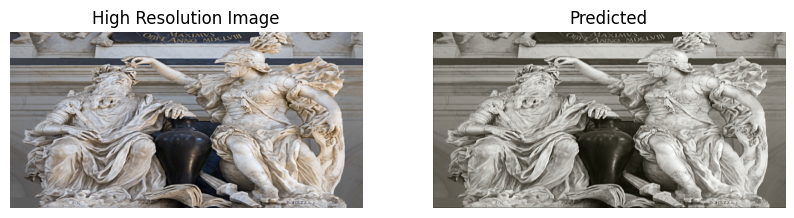

In [13]:
model = FSRCNN(4)
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

x_batch, y_batch = next(iter(val_loader))
x, y = x_batch[0], y_batch[0]
x = x.to(device)
pred = model(x)
pred = pred.cpu()
print("Predicted image", pred.shape)
print("High Resolution Image", y.shape)

# Convert tensors to numpy arrays
y = y.numpy().transpose(1, 2, 0)
pred = pred.detach().numpy().transpose(1, 2, 0)

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(y)
axes[0].set_title("High Resolution Image")
axes[0].axis("off")

axes[1].imshow(pred)
axes[1].set_title("Predicted")
axes[1].axis("off")


# HR and LR image comparasion

High Resolution image torch.Size([1020, 2040, 3])
Low Resolution image torch.Size([255, 510, 3])


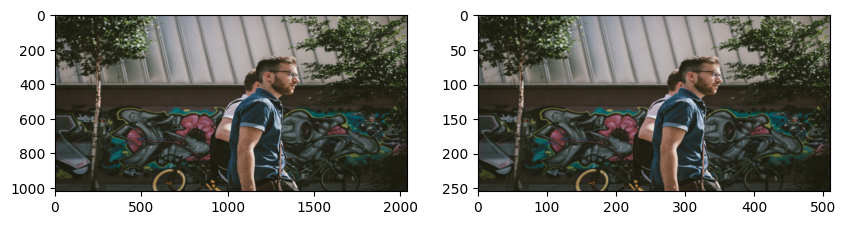

In [14]:
def train_imgs_visualization():
    """
    Does the plot for the training image
    """
    for imgs in train_loader:
        fig = plt.figure(figsize=(10, 7))

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)
        print("High Resolution image", img1.shape)

        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        print("Low Resolution image", img2.shape)
        break


def val_imgs_visualization():
    """
    Does the plot for the validation image
    """
    for imgs in val_loader:
        fig = plt.figure(figsize=(10, 7))

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)

        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        break


train_imgs_visualization()

In [15]:
end_time: float = time.time()
elapsed_time: float = end_time - start_time
elapsed_minutes: int = int(elapsed_time // 60)
elapsed_seconds: float = elapsed_time % 60

logger.info(f"⏱️ Total execution time: {elapsed_minutes}m {elapsed_seconds:.2f}s")
logger.info("✅ Notebook execution completed successfully.")

2025-07-16 18:20:26 - INFO - ⏱️ Total execution time: 130m 31.57s
2025-07-16 18:20:26 - INFO - ✅ Notebook execution completed successfully.


Built with ❤️ using Z by HP AI Studio.